<table class="tfo-notebook-buttons" align="left">
  
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1Ucml-eoXACTJ53-wijcMQIUgJhh_XVI2#scrollTo=gmvZWOqiO7G6"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://www.yingliu.site/post/what-is-pfam-database?utm_source=interview&utm_medium=ipynb&utm_campaign=protein"><img src="https://static.wixstatic.com/media/be6a38_31ef4d26304a49b3a65d13b1e25cce91~mv2.jpg/v1/fill/w_30,h_30,al_t,q_90,enc_auto/be6a38_31ef4d26304a49b3a65d13b1e25cce91~mv2.jpg" />Find description in my post</a>
  </td>

</table>

# 0. Environment

In [2]:
# from Bio import SeqIO
import re
import pandas as pd
from matplotlib import pyplot as plt
import glob
import os
import numpy as np

# from google.colab import drive
# drive.mount('/google_drive', force_remount=True)
folder = "./"



Mounted at /google_drive


Idealy the functions used in this script should be grouped in class and saved to import in this script. But I am running it here for demonstration purpose only.

# 1. Upload Data

## 1.1 Data introduction

This dataset is saved in google drive under folder **protein**.
- train
- dev
- test

Each folder contains a number of csv files, which have the following fields.
```
sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE
family_id: zf-Tim10_DDP
```
Description of fields:

- sequence: These are usually the input features to your model. Amino acid sequence for this domain.
There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite
uncommon: X, U, B, O, Z.
- family_accession: These are usually the labels for your model. Accession number in form PFxxxxx.y
(Pfam), where xxxxx is the family accession, and y is the version number.
Some values of y are greater than ten, and so 'y' has two digits.
- family_id: One word name for family.
sequence_name: Sequence name, in the form "$uniprot_accession_id/$start_index-$end_index".
- aligned_sequence: Contains a single sequence from the multiple sequence alignment (with the rest of the members of
the family in seed, with gaps retained.
Generally, the family_accession field is the label, and the sequence
(or aligned sequence) is the training feature.

This sequence corresponds to a domain, not a full protein.

The contents of these fields is the same as to the data provided in Stockholm
format by PFam at
ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam32.0/Pfam-A.seed.gz

[1] Eddy, Sean R. "Accelerated profile HMM searches."
PLoS computational biology 7.10 (2011): e1002195.

## 1.2 File source

In [2]:

train_files = glob.glob(os.path.join(folder,"train","*0"))
dev_files = glob.glob(os.path.join(folder,"dev","*0"))
test_files = glob.glob(os.path.join(folder,"test","*0"))

In [3]:
# upload train file

train_df = pd.DataFrame([])
for file in train_files:
  df = pd.read_csv(file)
  train_df = pd.concat([train_df, df])

In [4]:

# upload dev+test file
dev_test_df = pd.DataFrame([])
for file in dev_files + test_files:

  df = pd.read_csv(file)
  dev_test_df = pd.concat([dev_test_df, df])

In [5]:
# upload dev file
dev_df = pd.DataFrame([])
for file in dev_files:

  df = pd.read_csv(file)
  dev_df = pd.concat([dev_df, df])

In [6]:

# upload test file
test_df = pd.DataFrame([])
for file in test_files:

  df = pd.read_csv(file)
  test_df = pd.concat([test_df, df])

# 2. Data Analysis

## 2.1 family_accessions

In [7]:


#################################################################################
# The number of unique family acession in one file

df = pd.read_csv(train_files[0])
print("The unique family accession in file", df.family_accession.nunique())
print("The unique family id in file", df.family_id.nunique())

The unique family accession in file 6176
The unique family id in file 6176


In [5]:
#################################################################################
# define a function to split a string into first and last item

def split_str(string):
  return pd.Series(string.split(".", 1))


# turn label from string to int
def label_str(string):
    return pd.Series(int(string.split("PF")[1])).astype(int)

In [8]:
#################################################################################
# Family acession is separated by ".".
# How many type on each side of "."?

#################################################################################
# apply the split_str function to the "family_accession" column using apply()

df[["family_accession_front", "family_accession_back"]] = df['family_accession'].apply(split_str)
df["label"] = df['family_accession_front'].apply(label_str)
print("front of family_accession has unique value of ", df.family_accession_front.nunique())
print("back of family_accession has unique value of ", df.family_accession_back.nunique())

front of family_accession has unique value of  6176
back of family_accession has unique value of  33


In [9]:
#################################################################################
# Check every file in the training set


print("family_accession has unique value of ", train_df.family_accession.nunique())
train_df[["family_accession_front", "family_accession_back"]] = train_df['family_accession'].apply(split_str)
train_df["label"] = train_df['family_accession_front'].apply(label_str)
print("front part has unique value of ", train_df.family_accession_front.nunique())
print("back part has unique value of ", train_df.family_accession_back.nunique())

family_accession has unique value of  17929
front part has unique value of  17929
back part has unique value of  33


### 2.1.1 Check on family_accession front part/whole part

The number of domains in each family accession in sorted order.
[   1    1    1 ... 1761 1927 3637]


Text(0.5, 1.0, 'Histogram of family_accession size')

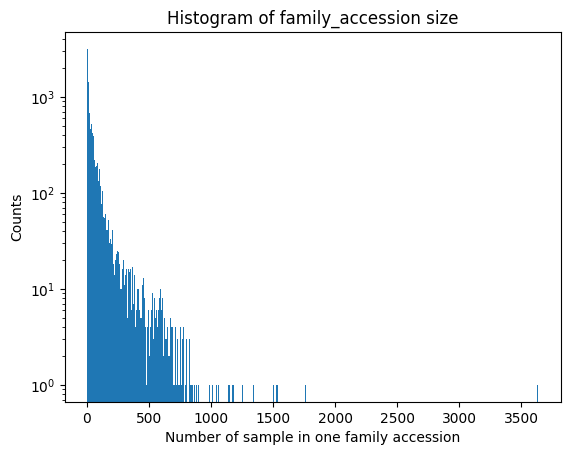

In [10]:
#################################################################################
# It looks like only the front part of family_acession matters
# Check the distribution of each family accession


train_family_accession, train_num_sample = \
  np.unique(train_df.family_accession, return_counts=True)

print("The number of domains in each family accession in sorted order.")
print(np.sort(train_num_sample))


#################################################################################
# Check the distribution of sample numbers in family.


import matplotlib.pyplot as plt
plt.hist(train_num_sample, bins='auto', log=True)  # arguments are passed to np.histogram
# plt.xscale('log')
plt.xlabel("Number of sample in one family accession")
plt.ylabel("Counts")
plt.title("Histogram of family_accession size")


The labels are imbalanced as the majority of the family accession has only one samples. It also raise the question that whether there are samples in the "dev" and "test" folder whose labels are not in the training set.

In [11]:
#################################################################################
# Check labels (family accession) in the "dev" folder.


print("family_accession has unique value of ", dev_df.family_accession.nunique())
dev_df[["family_accession_front", "family_accession_back"]] = dev_df['family_accession'].apply(split_str)
dev_df["label"] = dev_df['family_accession_front'].apply(label_str)
print("front part has unique value of ", dev_df.family_accession_front.nunique())
print("back part has unique value of ", dev_df.family_accession_back.nunique())


family_accession has unique value of  13071
front part has unique value of  13071
back part has unique value of  33


In [12]:
#################################################################################
# Check labels (family accession) in the "test" folder.


print("family_accession has unique value of ", test_df.family_accession.nunique())
test_df[["family_accession_front", "family_accession_back"]] = test_df['family_accession'].apply(split_str)
test_df["label"] = test_df['family_accession_front'].apply(label_str)
print("front part has unique value of ", test_df.family_accession_front.nunique())
print("back part has unique value of ", test_df.family_accession_back.nunique())

family_accession has unique value of  13071
front part has unique value of  13071
back part has unique value of  33


In [13]:
#################################################################################
# Check labels (family accession) in the "dev" and "test" folder.


print("family_accession has unique value of ", dev_test_df.family_accession.nunique())
dev_test_df[["family_accession_front", "family_accession_back"]] = dev_test_df['family_accession'].apply(split_str)
dev_test_df["label"] = dev_test_df['family_accession_front'].apply(label_str)
print("front part has unique value of ", dev_test_df.family_accession_front.nunique())
print("back part has unique value of ", dev_test_df.family_accession_back.nunique())

#################################################################################
# Check if there is any label which is not in the training set.


print("The follwoing labels are not in the training set:")
dev_test_df_family_accession = np.unique(dev_test_df.family_accession)
train_df_family_accession = np.unique(train_df.family_accession)
for label in dev_test_df_family_accession:
  if label not in train_df_family_accession:
    print(label)

family_accession has unique value of  13071
front part has unique value of  13071
back part has unique value of  33
The follwoing labels are not in the training set:


In [14]:
# Check the minimum training sample for families that exits in the test set, saying 5?

small_train_num = 5
num_train = []
for label in dev_test_df_family_accession:
  idx = np.argwhere(train_family_accession==label)
  num_train.append(train_num_sample[idx[0][0]])

print("The number of family accession in test and dev set that has training samples less than %s is \n"%small_train_num,
      sum(np.array(num_train) <= small_train_num))

The number of family accession in test and dev set that has training samples less than 5 is 
 0


In [15]:
# Check the minimum training sample for families that exits in the test set, saying 10?

small_train_num = 10
num_train = []
for label in dev_test_df_family_accession:
  idx = np.argwhere(train_family_accession==label)
  num_train.append(train_num_sample[idx[0][0]])

print("The number of family accession in test and dev set that has training samples less than %s is \n"%small_train_num,
      sum(np.array(num_train) <= small_train_num))

The number of family accession in test and dev set that has training samples less than 10 is 
 1014


In [16]:
# Check the minimum training sample for families that exits in the test set, saying 7?

small_train_num = 7
num_train = []
for label in dev_test_df_family_accession:
  idx = np.argwhere(train_family_accession==label)
  num_train.append(train_num_sample[idx[0][0]])

print("The number of family accession in test and dev set that has training samples less than %s is \n"%small_train_num,
      sum(np.array(num_train) <= small_train_num))

The number of family accession in test and dev set that has training samples less than 7 is 
 0


**This suggest that we do not need to concern about the the classes/labels/family_accessions which have $\le$ 7 samples.**

If I have no prior knowledge of the test set, I am risking the final accuracy but improve the computing efficiency as I am not spending time and resource with uncommon family accessions.

### 2.1.2 Filter train set
Remove some family accession from the training set, where the sample number of this family accession is equal or smaller than 7.

In [17]:
# Remove some labels in the training set.

filtered_family_accession = train_family_accession[np.where(train_num_sample > 7)]
filtered_train_df = \
        train_df.loc[train_df.family_accession.isin(filtered_family_accession)]

print("The filter process left us with %d samples out of the total %d samples"\
      %(len(filtered_train_df), len(train_df)))
print("The filter process left us with %d labels out of the total %d labels"\
      %(len(filtered_family_accession), len(train_family_accession)))


# remove some variables
train_df = filtered_train_df.copy()
del filtered_train_df

The filter process left us with 1072097 samples out of the total 1086741 samples
The filter process left us with 13912 labels out of the total 17929 labels


The number of domains in each family accession in sorted order.
[   8    8    8 ... 1761 1927 3637]


Text(0.5, 1.0, 'Histogram of filtered family_accession size')

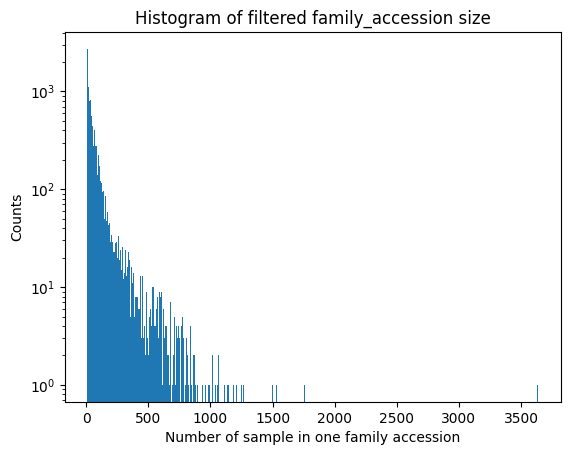

In [18]:
# Check the distribution of each family accession again


train_family_accession, train_num_sample = \
  np.unique(train_df.family_accession, return_counts=True)

print("The number of domains in each family accession in sorted order.")
print(np.sort(train_num_sample))


#################################################################################
# Check the distribution of sample numbers in family.


import matplotlib.pyplot as plt
plt.hist(train_num_sample, bins='auto', log=True)  # arguments are passed to np.histogram
# plt.xscale('log')
plt.xlabel("Number of sample in one family accession")
plt.ylabel("Counts")
plt.title("Histogram of filtered family_accession size")


### 2.1.3 Check on the family_accession back part
Would the back part have similar number of samples?
Disposed idea as I did not find phsical meaning in it.

In [19]:
# In each label group of the family_accession back, check the number of samples for each family accession


In [20]:
# Check the total number of sample in each family_accession back label

## 2.2 sequence

How many domains contain uncommon amino acids?

In [21]:
# How many domains contain uncommon amino acids

print("%d out of %d samples."%(sum(train_df.sequence.str.contains("X|U|B|O|Z")),
                               len(train_df)))

# one method of encoding uncommon amino acid is to use the same integer to represent all of them

747 out of 1072097 samples.


maximum sequence is  1972


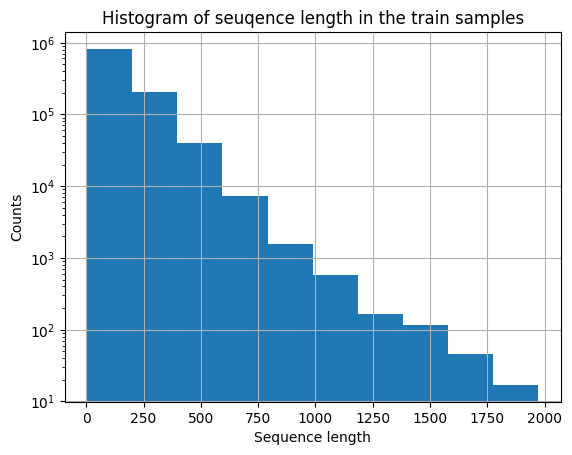

In [22]:
# Check the distribution of domain sequence length

train_df.sequence.apply(len).hist()
plt.yscale('log')
plt.xlabel("Sequence length")
plt.ylabel("Counts")
plt.title("Histogram of seuqence length in the train samples")

print("maximum sequence is ", train_df.sequence.apply(len).max())

Check amino acid unique numbers

In [23]:

# Find unique amino acids
unique_acid_series = train_df.sequence.apply(set)
unique_acid = set()
for item in unique_acid_series:
  unique_acid.update(item)
print("The unique acid in the traing set are \n", unique_acid)

# Assign the counts for each unique acid to each sample
for acid in unique_acid:
  train_df[acid] = train_df.sequence.map(lambda chars: chars.count(acid))

train_df.head()

The unique acid in the traing set are 
 {'D', 'O', 'N', 'V', 'S', 'E', 'G', 'X', 'Z', 'F', 'M', 'Y', 'B', 'K', 'R', 'Q', 'C', 'A', 'I', 'W', 'P', 'U', 'H', 'T', 'L'}


,family_id,sequence_name,family_accession,aligned_sequence,sequence,family_accession_front,family_accession_back,label,D,O,...,Q,C,A,I,W,P,U,H,T,L
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH,PF07661,13,7661,0,0,...,2,0,0,1,0,0,0,2,1,4
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...,PF08337,12,8337,39,0,...,25,7,29,21,5,19,0,21,40,68
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...,PF17917,1,17917,4,0,...,3,1,3,5,2,2,0,4,6,12
3,Transposase_20,Q981X5_RHILO/224-313,PF02371.16,VEAYQAMRGASFLVAVIFAAEI.GDV.RR.FDTPPQLMAFLGLVPG...,VEAYQAMRGASFLVAVIFAAEIGDVRRFDTPPQLMAFLGLVPGERS...,PF02371,16,2371,3,0,...,2,0,14,2,1,4,0,0,6,9
5,QRPTase_N,Q5JFR0_THEKO/15-102,PF02749.16,APFGDVTSEAVIPEDMKAR...AVIIAKQN.GVIA.GVEEAKA.LF...,APFGDVTSEAVIPEDMKARAVIIAKQNGVIAGVEEAKALFEHFGVK...,PF02749,16,2749,4,0,...,1,0,11,6,0,2,0,1,2,7


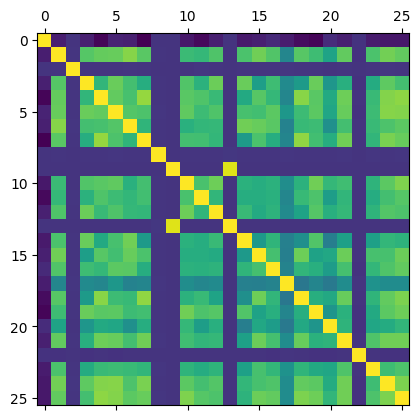

          label         D         O         N         V         S         E  \
label  1.000000 -0.076664 -0.000924 -0.074076 -0.161758 -0.058807 -0.073393   
D     -0.076664  1.000000  0.006130  0.691797  0.723781  0.724366  0.785662   
O     -0.000924  0.006130  1.000000  0.004711  0.004724  0.002930  0.007309   
N     -0.074076  0.691797  0.004711  1.000000  0.597626  0.732603  0.649853   
V     -0.161758  0.723781  0.004724  0.597626  1.000000  0.716479  0.659692   
S     -0.058807  0.724366  0.002930  0.732603  0.716479  1.000000  0.684975   
E     -0.073393  0.785662  0.007309  0.649853  0.659692  0.684975  1.000000   
G     -0.176829  0.700476  0.006721  0.558523  0.814527  0.671688  0.595293   
X      0.002368  0.004164 -0.000043  0.005827  0.004511  0.010246  0.004225   
Z     -0.001522 -0.000960 -0.000004 -0.000861  0.000058 -0.000177 -0.001143   
F     -0.103103  0.625266  0.002285  0.678437  0.698567  0.712706  0.570144   
M     -0.145440  0.607495  0.009020  0.578343  0.675

In [24]:
# Treat the number of each acid as features

num_acid_data = train_df.iloc[:,7:]


# Do they correlate?
import matplotlib.pyplot as plt
plt.matshow(num_acid_data.corr())
plt.show()

print(num_acid_data.corr())

Some observation:
- Z, U, B, X, O are almost indepandent with the others. It fits the discription that they are uncommon.
- Z is strongly correlated with B, But due to the small occurance, it does not mean anything.

In [54]:
# a quick PCA on number of acids to see if we can observe anything

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_feature = pca.fit_transform(num_acid_data)

# plot
import plotly.express as px
df = pd.DataFrame(pca_feature, columns=["pc1", "pc2", "pc3"])
df["family_accession_back"] = train_df["family_accession_back"].astype(int).to_list()

# data is too big for interactive visualisation. comment if it crashes.
fig = px.scatter_3d(df.sample(n=1000), x='pc1', y='pc2', z='pc3',
                    color='family_accession_back',
                    color_continuous_scale="Portland",)

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()


**Analysis**:
1. We can separate dataset by the end part of family_accession first. Then run the classification as they seem to follow the sequence length. (Not finished)


## 2.3 Alligned sequence

In [26]:
print("train set \n", train_df.head())
print("test set \n", test_df.head())

,family_id,sequence_name,family_accession,aligned_sequence,sequence,family_accession_front,family_accession_back,label
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGR..REVMAD....ACLQGMM..GCVYG..........TAG...,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...,PF12746,7,12746
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGK.PVSRRTAAASATVLLG.EK..........AFWLV.......,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...,PF01967,21,1967
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGT.C...D..VA...ME..AR.NQ.......T....G......,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...,PF13649,6,13649
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKV..G.................KEYQLLN....CD...,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...,PF03587,14,3587
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTD...............AMVVSSYLN..TDKSLV...,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...,PF17189,4,17189


In [27]:
# Uncommon amino acid are coded with the same numeric value.

str_to_int = {
    '.': 0,
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12, # Uncommon
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, # Pyrrolysine, Uncommon
    'X':23, # Unknown, Uncommon
    'Z':23, # Glutamic acid or GLutamine, Uncommon
    'B':23, # Asparagine or aspartic acid, Uncommon
    'J':23, # Leucine or isoleucine, not in dataset
    'start':24,
    'stop':25,
}

# Change string to numerica value
def encode_sequence(sequence):
  # turn string to integer
  return  [str_to_int[a] for a in sequence]

def encode_sequence_list(sequence_list):
  return [encode_sequence(seq) for seq in sequence_list]



Take 50 samples from one family to see the alligned sequence pattern.

In [53]:
import random

random_family = np.unique(train_df.family_accession_front)
random_family = random.sample(random_family.tolist(), 1)[0]
print("Family accession", random_family)
plot_samples = train_df[train_df.family_accession_front==random_family].aligned_sequence.to_list()
num = min(len(plot_samples), 50)
plot_samples = random.sample(plot_samples, num)
plot_matrix = encode_sequence_list(plot_samples)
print("Length of alligned sequence: ", len(plot_samples[0]))

import plotly.express as px

fig = px.imshow(plot_matrix)

fig.update_xaxes(title="alligned sequence")
fig.update_yaxes(title="sample")
fig.show()

Family accession PF12932
Length of alligned sequence:  257


**Analysis**:
1. Same family has same length. cluster dataset by length first.
2. Classification strategy: In each length group, Calculate mean of at each acid position, use the difference as a feature.

# 3.1 Feature Extraction (For Aligned sequence only)

In [29]:
# Find out samples in the same family acession and their corresponding alligned sequence length.

families = np.unique(train_df.family_accession)

def length_group(aligned_sequence):
  return len(aligned_sequence)

train_df["length"] = train_df.aligned_sequence.apply(length_group)
dev_df["length"] = dev_df.aligned_sequence.apply(length_group)
test_df["length"] = test_df.aligned_sequence.apply(length_group)



In [55]:
# Extract a group with the same length of aligned_sequence, view the family and sequence.

import random

random_length = np.unique(train_df.length)
random_length = random.sample(random_length.tolist(), 1)[0]

plot_samples = train_df[train_df.length==random_length]
print("Family labels: ", plot_samples.family_accession_front.unique())
print("Number of family is: ", len(plot_samples.family_accession_front.unique()))
plot_samples = plot_samples.sort_values(by="family_accession_front").aligned_sequence

# num = min(len(plot_samples), 100)
# plot_samples = plot_samples.sample(n=num, random_state=0)
plot_samples = plot_samples.to_list()
plot_matrix = encode_sequence_list(plot_samples)

import plotly.express as px

fig = px.imshow(plot_matrix)

fig.update_xaxes(title="alligned sequence")
fig.update_yaxes(title="sample")
fig.show()


Family labels:  ['PF07775' 'PF12458' 'PF09752' 'PF15802' 'PF13163' 'PF05872']
Number of family is:  6


**Analysis**:
1. Each length group contains family numbers from 1 to about 50.
2. In each length group, the number of sample are still unbalanced.
3. Strategy: In each length group,
  - Find the mean at each position in each group
  - Calculate the difference between new sample and the mean.
  - Use difference as feature to classify data.

# 4.1 Model plan (aligned sequence only)

1. Find length group of sample based on aligned sequence. The length of the aligned sequence defined the possible family it could be. (train process)
```
For example: 1200: ['PF01237' 'PF00723' 'PF10395'].
The aligned sequence with length 1200 can only belong to these families.
```

2. Find mean value at each position in the family. (train process)

3. Find length group of the test/dev sample.
4. calculate difference between sample and the stored mean value
5. Use mean value as feature to classify family type


This following training and testing process rely on a random choice of alligned sequence length. It can also be wrapped in a class so it applies to the full dataset. Here I am not going to extend it as the accuracy seems to be 100% all the time.

## Train process

In [31]:
# Extract one group with the same length of aligned_sequence, classify within the group

import random

random_length = np.unique(train_df.length)
random_length = random.sample(random_length.tolist(), 1)[0]
subgroup_train_df = train_df[train_df.length==random_length]

print("Aligned sequence length is ", random_length)
print("Family labels: ", subgroup_train_df.family_accession_front.unique())
print("Number of family is: ", len(subgroup_train_df.family_accession_front.unique()))


Aligned sequence length is  532
Family labels:  ['PF10354' 'PF00930']
Number of family is:  2


In [32]:
subgroup_train_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,family_accession_front,family_accession_back,label,D,O,...,C,A,I,W,P,U,H,T,L,length
1416,DUF2431,M4ECC1_BRARP/21-188,PF10354.9,.LLVGEGDFSFSLCL....ASAF...GSA..TN................,LLVGEGDFSFSLCLASAFGSATNITATSLDSEDELSKKYMDAMVNV...,PF10354,9,10354,9,0,...,2,12,6,1,3,0,7,7,15,532
6635,DUF2431,B9I0H7_POPTR/32-197,PF10354.9,.LLVGDGDFSFAVCL....AEAF...GSA..TN................,LLVGDGDFSFAVCLAEAFGSATNIVATSLYSEEMMRLKYSGAASNL...,PF10354,9,10354,5,0,...,2,14,5,1,5,0,8,7,16,532
11400,DUF2431,A5DZJ2_LODEL/81-302,PF10354.9,.LLVGEGDFSFAKSL....I...........LQNY..............,LLVGEGDFSFAKSLILQNYVRPENLVATSLDSQEEVMAKYPDVDKT...,PF10354,9,10354,18,0,...,1,9,11,2,7,0,8,9,18,532
2765,DUF2431,F7VSD3_SORMK/99-274,PF10354.9,.LLVGDGDLSFAVSL....V...........EHY...............,LLVGDGDLSFAVSLVEHYHCTNLTATVYEKDLDELSAKYPHVRANV...,PF10354,9,10354,12,0,...,3,14,7,1,7,0,8,9,17,532
3443,DUF2431,K0KN77_WICCF/69-267,PF10354.9,.MLVGEGDFSFAASC....L...........QQEY..............,MLVGEGDFSFAASCLQQEYLQPSKLIITSFDNSANELALKYPHTFP...,PF10354,9,10354,11,0,...,2,5,9,3,8,0,6,7,22,532


In [33]:
# Define the centroid of each family

centroid = {}
np.unique(subgroup_train_df.label)
labels = np.unique(subgroup_train_df.label)
for label in labels:
  encoded_seq = subgroup_train_df[subgroup_train_df.label==label].aligned_sequence
  encoded_seq = encode_sequence_list(encoded_seq.to_list())
  centroid_seq = np.mean(encoded_seq, axis=0)
  centroid[label] = centroid_seq

## Test process

In [34]:
# Prediction, define dataset

X_new = test_df

In [35]:
# Pick the dataset that fits the length
X_new = X_new[X_new.length==random_length]

In [36]:
# Predict label
# Whichever centroid is closer to the sample is the final family acsession.

encoded_seq_new = encode_sequence_list(X_new.aligned_sequence.to_list())
y_gt = X_new.label
y_pred = np.zeros((len(y_gt), len(labels)))
for i, label in enumerate(labels):
  difference_to_label = np.array(encoded_seq_new) - centroid[label]
  y_pred[:, i] = np.linalg.norm(difference_to_label, axis=1)
y_pred = labels[np.argmin(y_pred, axis=1)]


## Metric

In [37]:
# Calculate Accuracy

print("Accuracy is ", sum(np.array(y_pred)==np.array(y_gt))/len(y_gt))

Accuracy is  1.0


The accuracy is always 1 with this method so I will move to sequence only analysis.

# 3.2 Feature Extraction (For Sequence only, if there is no alligned information)

According to a review [paper](https://doi.org/10.34133/research.0011) of biological sequence classfication, the feature extraction methods for Amino Acid sequence are shown as below.
Even though it refers to protein sequence in this figure, I am using similar techniques as the domain length is reasonably long.

 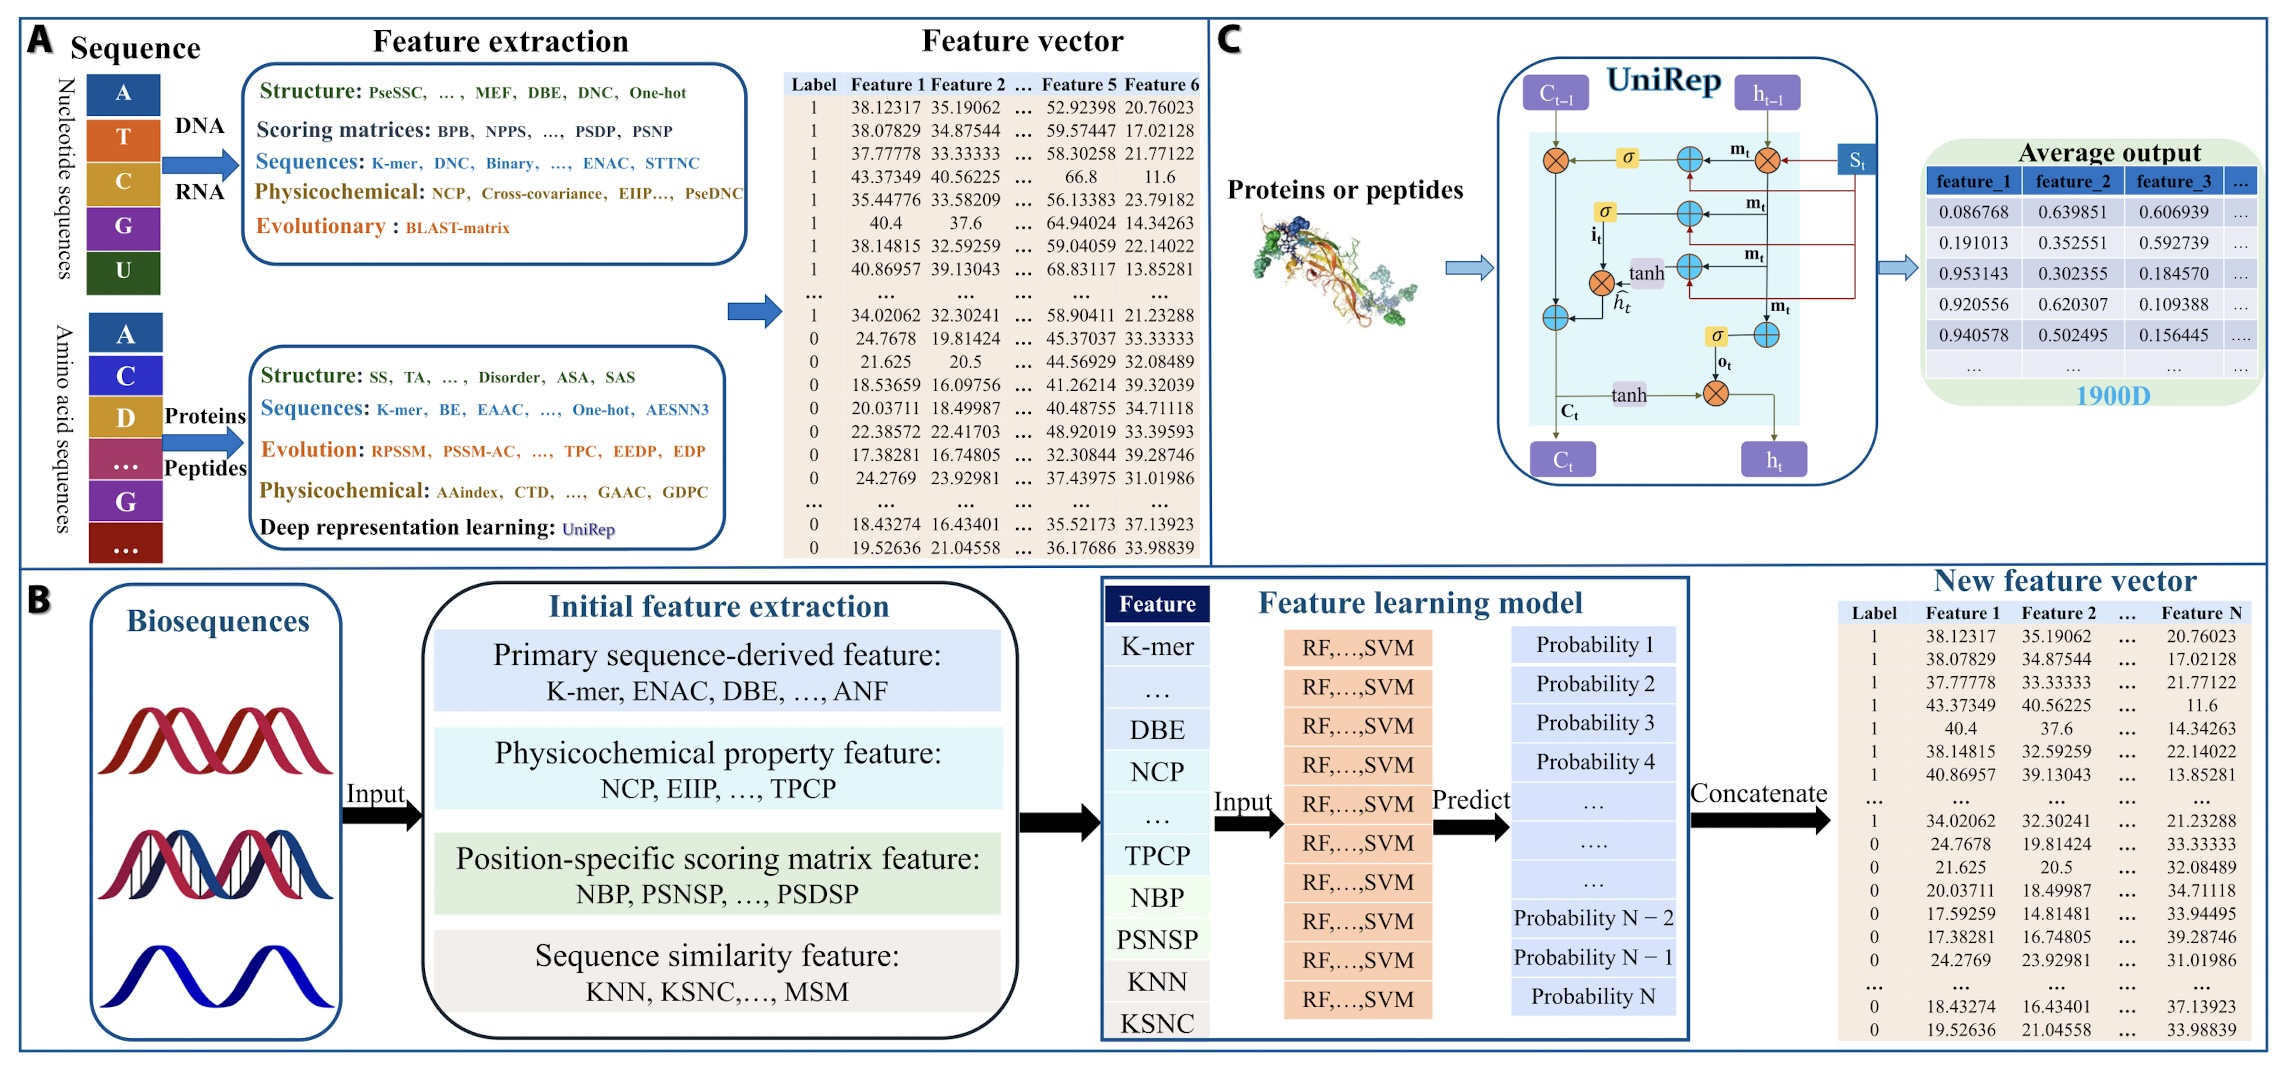


There are two methods applied here for the feature extraction. One is a standard autoencoder and another one is UniRep from [paper](https://doi.org/10.1038/s41592-019-0598-1).

Both methods would take in input of various size and generate 1900 features from each sequence sample.


*Why 1900 features?* \\
UniRep is an open source code wrapped in docker where model weight for 64 features and 1900 features can be downloaded to use without extra training. The UniRep 64 feautres cannot deal with sequence length which are over about 250 acids.

## 3.2.1 AutoEncoder

### Prepare input

The input data for the autoencoder has various size. Each batch could have a different input shape but the same batch size. The size will be unified in the Encoder part with a global average pooling method.

In [38]:
# Create input batches with the same batch size but different input length.
# In each batch, the data should have a rectangular shape.
# This method is inspired by UniRep data preparation and modified accordingly.


import pandas as pd
import numpy as np

def split_by_batch(index_array, batch_size=5):
  """
  Index_array: the indexs of sequence from one group.

  Split index by batch size and add duplicate data from first sample if it's
  not enough.
  In one group, the sequence will be padded at the end with 0 until it reaches
  the required length of that group.
  """

  while len(index_array) % batch_size != 0:
    required_sample = batch_size - len(index_array) % batch_size
    added_index = index_array[:required_sample]
    index_array = np.append(index_array, added_index)
  return np.reshape(index_array, (-1, batch_size))

def pad_sequence(encoded_seq_list, group_id, interval=50):
  """
  Pad sequence at the end until it reaches the length defined in the group
  Example:
  >>> encoded_seq_list = [[9,2,4,2], [4,5], [6,7,8,3,66,4,3]]
  >>> group_id = [0, 0, 1]
  >>> interval = 5

  # The defined sequence length in groups should be
  >>> interval * (group_id + 1)
  [5, 5, 10]

  # Each encoded sequence are then padded to the defined length as
  >>> [[9,2,4,2,0], [4,5,0,0,0], [6,7,8,3,66,4,3,0,0,0]]

  """
  return [seq + [0] * (interval * (group_id[i] + 1) - len(seq)) \
          for i, seq in enumerate(encoded_seq_list)]

def encode_sequence(sequence):
  # turn string to integer
  return [str_to_int["start"]] + [str_to_int[a] for a in sequence] + [str_to_int["stop"]]

def encode_sequence_list(sequence_list):
  return [encode_sequence(seq) for seq in sequence_list]

def bucket_batch_pad(list_of_sequence, batch_size=128, interval=50, upper=1500):
  """
  For each sequence, group them by seq length of 0-50, 50-100, 100-150.
  When it goes above 1500, group with 2000.
  This is based on the histogram of filtered train data.
  Assign sequence from same group to one list.

  Length of each protein sequence plut head and tail.
  """
  len_sequence = [len(protein) + 2 for protein in list_of_sequence]
  # group each sequence based on length, length of 0-49 belongs to group 0
  group_sequence = np.array(len_sequence) // interval

  group_sequence = np.where(group_sequence > upper // interval,
                            max(len_sequence) // interval, group_sequence)
  df = pd.DataFrame(np.array([len_sequence, group_sequence]).T,
                    columns=("length", "group"))
  groups = []
  for group_id in df.group.unique():
    # In each group, find the sample index of this group
    group_index = df.index[df.group==group_id].to_numpy()
    # If the the number of sample is not enough to form integer batches.
    # copy data from top until we can have interger number of batches
    # if batch_shape has a shape of (2, 64), it means the samples are enough to form 2 batches
    # and each batch has 64 samples.
    batch_shape = split_by_batch(group_index, batch_size=batch_size)

    groups.append(batch_shape)

  # groups has the shape of [number of group, number of batch, batch_size]. In
  # each group, the number of batch is different
  return groups, df



In [39]:
# Create a data generator to feed data to model batch by batch

def data_generator(df, batch_size=128, interval=50):

  # Takes dataframe of protein, turn sequence series to a list of strings
  list_of_sequence = df.sequence.tolist()
  # separate each sequence to a group based on it's length
  group_index, group_df = bucket_batch_pad(list_of_sequence, batch_size=batch_size, interval=interval)
  # encode sequence from string to integer
  encoded_seq_list = encode_sequence_list(list_of_sequence)
  # pad each sequence to a unique length in each group
  padded_seq = pad_sequence(encoded_seq_list, group_df.group, interval=interval)
  # group_index has the shape of [number of group, number of batch, batch_size].
  # In each group, the number of batch is different
  for index in group_index:
    # index has the shape of (number of batch, batch size)
    for batch_index in index:
      input_data = np.zeros((batch_size, len(padded_seq[batch_index[0]])))
      for i, ind in enumerate(batch_index):
        input_data[i,:] = padded_seq[ind]
      input_data = input_data / str_to_int["stop"]
      # Yield the data in batches
      input_data = np.expand_dims(input_data, -1)
      yield input_data, input_data

In [40]:
batch_size = 256
num_epochs = 20
shuffle_buffer_size = 20
latent_dim = 1900

In [41]:
# Create a TensorFlow dataset for the training set
import tensorflow as tf
train_dataset = tf.data.Dataset.from_generator(lambda:
                                      data_generator(train_df,
                                                    batch_size=batch_size),
                                      output_types=(tf.float32, tf.float32))
train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size).repeat(num_epochs)

dev_dataset = tf.data.Dataset.from_generator(lambda:
                                      data_generator(dev_df,
                                                    batch_size=batch_size),
                                      output_types=(tf.float32, tf.float32))


Instructions for updating:
Use output_signature instead


### Construct model

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None, 1)]         0         
                                                                 
 conv1 (Conv1D)              (None, None, 2100)        6300      
                                                                 
 global_average_pooling1d (  (None, 2100)              0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4302848   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                            

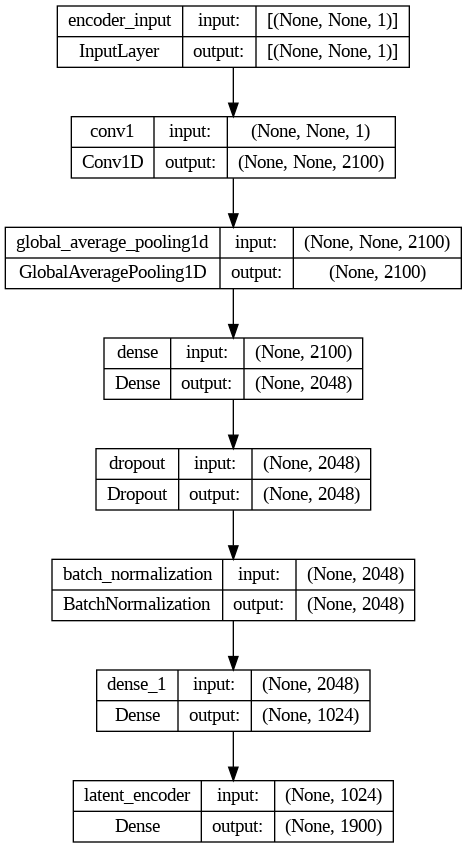

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, \
                                    BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Build encoder model

input = Input(shape=(None, 1), name='encoder_input')
conv = Conv1D(2100, 2, name='conv1')(input)
maxp = GlobalAveragePooling1D(data_format='channels_last')(conv)
x = Dense(2048, activation='relu')(maxp)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
latent_feature = Dense(latent_dim, activation='relu', name='latent_encoder')(x)

# instantiate encoder model
encoder = Model(input, latent_feature, name='encoder')
encoder.summary()
tf.keras.utils.plot_model(encoder, to_file='AutoEncoder_encoder.png', show_shapes=True)


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_decoder (InputLayer  [(None, 1900)]            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1024)              1946624   
                                                                 
 dense_3 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_4 (Dense)             (None, 2100)              4302900   
                                                                 
Total params: 8348724 (31.85 MB)
Trainable params: 8348724 (31.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


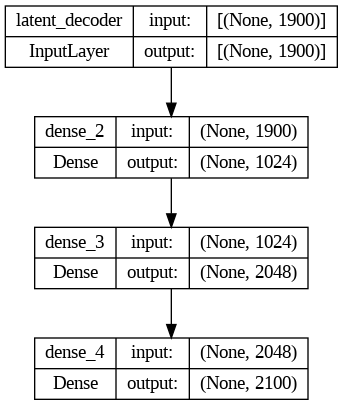

In [43]:

# build decoder model

latent_input = Input(shape=(latent_dim,), name='latent_decoder')
# x = tf.keras.layers.Dense(128, activation='relu')(latent_input)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(latent_input)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
output = tf.keras.layers.Dense(2100, activation='relu')(x)

# instantiate decoder model
decoder = tf.keras.Model(latent_input, output, name='decoder')
decoder.summary()
tf.keras.utils.plot_model(decoder, to_file='AutoEncoder_decoder.png', show_shapes=True)



Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None, 1)]         0         
                                                                 
 encoder (Functional)        (None, 1900)              8363016   
                                                                 
 decoder (Functional)        (None, 2100)              8348724   
                                                                 
Total params: 16711740 (63.75 MB)
Trainable params: 16707644 (63.73 MB)
Non-trainable params: 4096 (16.00 KB)
_________________________________________________________________


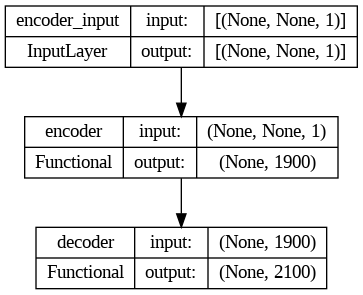

In [44]:
# Add them together
output = decoder(encoder(input))
model = tf.keras.Model(input, output, name='AutoEncoder')
model.summary()

tf.keras.utils.plot_model(model, to_file='AutoEncoder_all.png', show_shapes=True)

### Define loss

In [45]:
global MSE
import tensorflow as tf
MSE = tf.keras.losses.MeanSquaredError()
def mse_loss(input, output):
  input_value = tf.squeeze(input)
  output_value = output[:,:tf.shape(input_value)[-1]]
  return MSE(input_value, output_value) + MSE(0, output[:,tf.shape(input_value)[-1]:])



### Fit model

This model is not tuned properly.  

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                  monitor='val_loss',
                                                  min_delta=0,
                                                  patience=3,
                                                  verbose=0,
                                                  mode='auto',
                                                  baseline=None,
                                                  restore_best_weights=False,
                                                  # start_from_epoch=0
                                              )

checkpoint_filepath = os.path.join(folder,"model/tmp/checkpoint_%d"%latent_dim)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

################################################### Use trained weight
# from tensorflow.keras.models import load_model
# saved_model = load_model(os.path.join(folder,"model","autoencoder_%d"%latent_dim),
#                         custom_objects={"mse_loss": mse_loss})
# # model.set_weights(saved_model.get_weights())
######################################################################

model.compile(optimizer="adam", loss=mse_loss)
model.summary()

model.fit(train_dataset, epochs=num_epochs, validation_data=dev_dataset,
          callbacks=[early_stopping, model_checkpoint_callback],
          batch_size=batch_size, verbose=1)


model.save(os.path.join(folder,"model","autoencoder_%d"%latent_dim))

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None, 1)]         0         
                                                                 
 encoder (Functional)        (None, 1900)              8363016   
                                                                 
 decoder (Functional)        (None, 2100)              8348724   
                                                                 
Total params: 16711740 (63.75 MB)
Trainable params: 16707644 (63.73 MB)
Non-trainable params: 4096 (16.00 KB)
_________________________________________________________________
Epoch 1/20
84100/84100 [==============================] - 1688s 20ms/step - loss: 0.0676 - val_loss: 0.1315
Epoch 2/20
84100/84100 [==============================] - 1683s 20ms/step - loss: 0.0612 - val_loss: 1.4394
Epoch 3/20
84100/84100 [==============================] - 1

### Extract feature

In [49]:
latent_dim = 64
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
model = load_model(os.path.join(folder,"model","autoencoder_%d"%latent_dim),
                   custom_objects={"mse_loss": mse_loss})
encoder = Model(model.input, model.layers[1].output)

In [50]:
# Change data generator for prediction

def find_group_id(list_of_sequence, interval=50, upper=1500):
  """
  For each sequence, group them by seq length of 0-50, 50-100, 100-150.
  When it goes above 1500, group with 2000.
  This is based on the histogram of filtered train data.
  Assign sequence from same group to one list.

  Length of each protein sequence plut head and tail.
  """
  len_sequence = [len(protein) + 2 for protein in list_of_sequence]
  # group each sequence based on length, length of 0-49 belongs to group 0
  group_sequence = np.array(len_sequence) // interval

  group_sequence = np.where(group_sequence > upper // interval,
                            max(len_sequence) // interval, group_sequence)
  return group_sequence

def data_generator_prediction(df, interval=50):

  # Takes dataframe of protein, turn sequence series to a list of strings
  list_of_sequence = df.sequence.tolist()
  # separate each sequence to a group based on it's length
  group_id = find_group_id(list_of_sequence)
  # encode sequence from string to integer
  encoded_seq_list = encode_sequence_list(list_of_sequence)
  # pad each sequence to a unique length in each group
  padded_seq = pad_sequence(encoded_seq_list, group_id, interval=interval)
  for sequence in padded_seq:
    yield np.expand_dims(np.array([sequence]), -1)



In [51]:
# #  Check AutoEncoder performance

# for i, data in enumerate(data_generator_prediction(dev_df.iloc[:3])):
#   y_pred = model.predict(data)
#   y_gt = data.flatten()
#   print("Real sequence is ", y_gt)
#   print("predicted sequence is ", y_pred)


In [52]:
# Extract feature, The predicted result is big. Hence they are processed in chunks wiht 10k samples

chunksize = 10000

# Train part
for i in range(len(train_df) // chunksize):
  train_dataset = tf.data.Dataset.from_generator(lambda:
                      data_generator_prediction(
                          train_df.iloc[i*chunksize:(i+1)*chunksize],
                          ),
                      output_types=(tf.float32))



  feature = encoder.predict(train_dataset)
  train_feature_encoder = pd.DataFrame(feature,
                                       columns=[i for i in range(feature.shape[1])])
  train_feature_encoder["family"] = \
    train_df.iloc[i*chunksize:(i+1)*chunksize].family_accession.values
  train_feature_encoder.to_csv(os.path.join(folder,"feature",
                                          "train_features_encoder_%d.csv"%latent_dim),
                              mode='a', header=False, index=False)

# Dev dataset
for i in range(len(dev_df) // chunksize):

  dev_dataset = tf.data.Dataset.from_generator(lambda:
                        data_generator_prediction(
                            dev_df.iloc[i*chunksize:(i+1)*chunksize],
                            ),
                        output_types=(tf.float32))

  feature = encoder.predict(dev_dataset)
  dev_feature_encoder = pd.DataFrame(feature,
                                     columns=[i for i in range(feature.shape[1])])
  dev_feature_encoder["family"] = \
    dev_df.family_accession.iloc[i*chunksize:(i+1)*chunksize].values
  dev_feature_encoder.to_csv(os.path.join(folder,"feature",
                                          "dev_features_encoder_%d.csv"%latent_dim),
                             mode='a', header=False, index=False)

10000/10000 [==============================] - 19s 2ms/step


## 3.2.2 UniRep

I used **UniRep** code ([GitHub](https://github.com/churchlab/UniRep/tree/master)) from this [paper](https://doi.org/10.1038/s41592-019-0598-1) to extract features.

The code uses Tensorflow 1.3 with python 3.5. It is complicated to reinstall the environmentn in colab. So I used the [JAX wrapper](https://github.com/ElArkk/jax-unirep) version.

The explaination of UniRep can be found in my [post](https://www.yingliu.site/post/a-summary-of-research-paper-in-unified-representation-unirep-of-protein).

In the UniRep feature extraction, the **mLSTM** which produce 1900 features were used.

The advantage of this model is that I can utilised the trained weight by the authors for the sequence feature extraction. The disadvantage is that it takes awfully long time.



In [ ]:
!pip install jax-unirep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
from jax_unirep import get_reps
# h_avg is the canonical "reps"
# Use UniRep to encode sequence. save in each loop as it takes long time.
# Tried Multiprocessing but get_reps seems not to work well with it. Need further analysis
# Data are saved in the feature folder

dataset = "dev"
df = eval(dataset + "_df")

sequence_list = df.sequence.tolist()
family_list = df.family_accession_front.tolist()

gap = 100

def get_rep_UniRep(i):
  h_avg, h_final, c_final= get_reps(sequence_list[i*gap :(i+1)*gap], mlstm_size=1900)

  # # creat dataframe with feature and label
  h_avg_df = pd.DataFrame(h_avg, columns=["feature%d"%j for j in range(1900)])
  h_avg_df["family"] = family_list[i*gap :(i+1)*gap]
  # # Save data everytime as it takes a very long time
  h_avg_df.to_csv(os.path.join(folder,"feature", "%s_features_unirep_1900.csv"%dataset),
            mode='a', header=False, index=False)


for num in range(len(sequence_list) // gap):
  get_rep_UniRep(num)

## 3.2.3 Feature Analysis (can be run directly after environment)

Choose features from
1. train_features_unirep_1900.csv
2. train_features_unirep_64.csv
3. train_features_encoder_1900.csv
4. train_features_encoder_64.csv

In [56]:
# When feature number is 64, I can load the whole set
latent_dim = 1900
chunksize = 10000
feature_extraction_model = "encoder" #encoder, unirep
dataset_key = ["train", "dev"]  # train, dev, test
data = {}


for key in dataset_key:
  data[key] = pd.read_csv(os.path.join(folder,
                                        "feature",
                                        "%s_features_%s_%d.csv"%(key,
                                            feature_extraction_model,
                                                          latent_dim)),
                          names=([i for i in range(latent_dim)] + ["family"]),
                          chunksize=chunksize,)
  for chunk in data[key]:
    data[key] = chunk
    break


  # UniRep extracted feature only saved label as "family". It is family_accession_font data.
  # Comment first line for UniRep data
  data[key][["family", "family_back"]] = data[key]['family'].apply(split_str)
  data[key]["label"] = data[key]['family'].apply(label_str)


### PCA view

In [57]:
# Check if data can be clustered using PCA.

# a quick PCA on number of acids to see if we can observe anything
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
pca_feature = pca.fit_transform(data["train"].iloc[:,:latent_dim])

# plot
import plotly.express as px
import random
df = pd.DataFrame(pca_feature, columns=["pc%d"%i for i in range(pca_feature.shape[1])])
feature_choice = random.sample(df.columns.tolist(), 3)
# feature_choice = df.columns.tolist()[:3]


# Choose a label to show
# df["family"] = chunk_df.family_back.values.astype(int)
df["label"] = data["train"].label.values

# # Choose random 1000 samples because the dataset is too big
plot_df = df.sample(n=1000)
# data is too big for interactive visualisation. comment if it crashes.
fig = px.scatter_3d(plot_df,
                    x=feature_choice[0],
                    y=feature_choice[1],
                    z=feature_choice[2],
                    color='label',
                    color_continuous_scale="Portland",
                    )

fig.update_traces(
                  marker=dict(size=4,
                              line=dict(width=0,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()


**Analysis for Autoencoder feature**: \\
1. PC1 has range from 0 to 300 while PC2 is 10000 times smaller and PC3 is even worse. Potentially the PCA need to be whitened.
2. The PCs forms connecting straight lines ==>
It means that the data can be separate into different clusters. each cluster owns the data in this straight line. In each cluster, the data can be spearate linearly.  
3. The color does not change smoothly for both front of the family and back of the family.

**Next step**:
1. try DBscan to cluster samples; --> Proved not good clustering in the later analysis.
2. Try decision tree.

**Analysis for UniRep feature**: \\
1. The PCA feature doesnot show obvious clustering from the observation ==> no unsupervised clustering.
2. It doesnot suit few-shot learning unless it is expanded to higher dimension with the help of blessing of dimensionality. But I do not recommand that as 1900 is already a big dimension.

**Next step**:
1. try some simple fast classifier

# 4.2 Model plan (For sequence only, no aligned information)


**Model proposal**:
1. Decision tree related model for classification directly. This is due to a clear spearation of data in principle components observation.  

2. One vs. many classification using few-shot learning (such as centroid classifier).
The evaluation tool could be ROC curve which have a threshold to decide the performance. (not finished, only confusion matrix were generated)

3. Unsupervised learning to cluster the data first, then run smaller classification. This method is nor recommanded as no clear indication of the clustering performance. DBScan and Spectral clustering did not show good performance in the clustering yet. (not finished)


## 4.2.1 Define metric (regression)

Treat this classfication as a regression problem.
Metric is the mean squared error between the predicted value and the normalised family label.

$$MSE = \frac{1}{N}\sum_i^N{(y_i - y_{i,pred})^2}$$

Or a simple multiclassification accuracy

## 4.2.2 load saved features

Upload extracted feature and run PCA transformation

In [16]:
# When feature number is 64, I can load the whole set
latent_dim = 1900
chunksize = 10000
feature_extraction_model = "unirep" #encoder, unirep
dataset_key = ["train", "dev"]
data = {}


for key in dataset_key:
  data[key] = pd.read_csv(os.path.join(folder,
                                        "feature",
                                        "%s_features_%s_%d.csv"%(key,
                                            feature_extraction_model,
                                                          latent_dim)),
                          names=([i for i in range(latent_dim)] + ["family"]),
                          chunksize=chunksize,)
  for chunk in data[key]:
    data[key] = chunk
    break

  # UniRep extracted feature only saved label as "family". It is family_accession_font data.
  # Comment first line for UniRep data

  # data[key][["family", "family_back"]] = data[key]['family'].apply(split_str)
  data[key]["label"] = data[key]['family'].apply(label_str)


In [8]:
data["train"].head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,family,family_back,label
0,0.0,0.0,1877.9133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PF07661,13,7661
1,0.0,0.0,3535.7092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PF08337,12,8337
2,0.0,0.0,3889.0286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PF17917,1,17917
3,0.0,0.0,3743.4905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PF02371,16,2371
4,0.0,0.0,3544.3225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PF02749,16,2749


In [17]:
# PCA transformation
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
pca_feature = {}
pca.fit_transform(data["train"].iloc[:,:latent_dim])

for key in dataset_key:
  pca_feature[key] = pca.transform(data[key].iloc[:,:latent_dim])

## 4.2.3 Develop model

### 4.2.3.1 quick test for extracted feature

### quick nn

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, \
                                    BatchNormalization, Dropout
from tensorflow.keras.models import Model


model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=latent_dim),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='relu')
])

In [62]:
# This NN is not tuned, There might be problem with node reaching 0 or run into saddle points (less likely).
batch_size = 256
num_epochs = 200

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                  monitor='val_loss',
                                                  min_delta=0,
                                                  patience=3,
                                                  verbose=0,
                                                  mode='auto',
                                                  baseline=None,
                                                  restore_best_weights=False,
                                                )

model.compile(optimizer="adam", loss="mse")
model.summary()

normalised_label_train = data["train"]["label"]/max(data["train"]["label"])
normalised_label_dev = data["dev"]["label"]/max(data["train"]["label"])
model.fit(pca_feature["train"], normalised_label_train,
          epochs=num_epochs,
          validation_data=(pca_feature["dev"], normalised_label_dev),
          callbacks=[early_stopping],
          batch_size=batch_size,
          verbose=1)

model.save(os.path.join(folder,"model","nn_classifier_encoder_feature"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              1946624   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2471937 (9.43 MB)
Trainable params: 2471937 (9.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
118/11

In [63]:
# label = model.predict(pca_feature["dev"])
# print(np.round(label * max(data["train"]["label"]), 0))
# print(data["dev"]["label"])

In [ ]:
# label * max(data["train"]["label"])

#### tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_split=7,class_weight="balanced")
tree.fit(pca_feature["train"], data["train"]["label"])
tree.score(pca_feature["dev"], data["dev"]["label"])

0.005

### 4.2.3.2 Clustering

#### dbscan (Dispose)

In [18]:
from sklearn.cluster import DBSCAN

label = DBSCAN(eps=0.2, min_samples=7).fit_predict(pca_feature["train"])


#### spectral cluster (Dispose)

In [12]:
from sklearn.cluster import SpectralClustering


label = SpectralClustering(n_clusters=20,
         assign_labels='discretize',
         random_state=0).fit_predict(pca_feature["train"])

#### Check unsupervised clustering result

In [19]:
# plot
import plotly.express as px
import random
df = pd.DataFrame(pca_feature["train"], columns=["pc%d"%i for i in range(pca_feature["train"].shape[1])])
feature_choice = random.sample(df.columns.tolist(), 3)

# Choose label
df["label"] = label

# # Choose random 1000 samples because the dataset is too big
plot_df = df.sample(n=1000)
# data is too big for interactive visualisation. comment if it crashes.
fig = px.scatter_3d(plot_df,
                    x=feature_choice[0],
                    y=feature_choice[1],
                    z=feature_choice[2],
                    color='label',
                    color_continuous_scale="Portland",
                    )

fig.update_traces(
                  marker=dict(size=4,
                              line=dict(width=0,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

**Analysis**:
1. Neither dbscan or spectral cluster can cluster them. I will use customer methods
2. Use few shot learning for one-vs-many classification based on this [paper](https://doi.org/10.1109/IJCNN54540.2023.10191135).

### 4.2.3.3 Few shot learning

In [21]:
# Upload data, same as 4.2.2
# When feature number is 64, I can load the whole set
latent_dim = 1900
chunksize = 30000
feature_extraction_model = "unirep" #encoder, unirep
dataset_key = ["train", "dev"]
data = {}


for key in dataset_key:
  data[key] = pd.read_csv(os.path.join(folder,
                                        "feature",
                                        "%s_features_%s_%d.csv"%(key,
                                            feature_extraction_model,
                                                          latent_dim)),
                          names=([i for i in range(latent_dim)] + ["family"]),
                          chunksize=chunksize,)
  for chunk in data[key]:
    data[key] = chunk
    break

  # UniRep extracted feature only saved label as "family". It is family_accession_font data.
  # Comment first line for UniRep data

  # data[key][["family", "family_back"]] = data[key]['family'].apply(split_str) # uncomment for encoder features
  data[key]["label"] = data[key]['family'].apply(label_str)


In [53]:
# Extract one family and classify against the rest

import random

random_label = np.unique(data["train"].label)
random_label = random.sample(random_label.tolist(), 1)[0]
subgroup_train_data = data["train"][data["train"].label==random_label]

print("This random label is ", random_label)
print("This random label has sample number of: ", len(subgroup_train_data))


This random label is  1773
This random label has sample number of:  6


In [54]:
# Define classifier

class CentroidClassifier:
	""" Classifier based on Centroids

	A classifier based on theoretical results from Demystification of Few-shot Learning.

	Parameters
	----------
	centroid_class : int, default 1 (few shots)
		The class of data to based correctors upon

	"""

	def __init__(self, centroid_class=1):
		self.centroid_class = centroid_class

	def fit(self, X, y):

		# find single class of data
		samples = X[y== self.centroid_class]

		# calculate centroid and norm
		self.x_mean = np.mean(samples, axis=0)
		self.x_norm = np.linalg.norm(self.x_mean, ord=2)

		# calculate weights and estimate intercept
		self.coef_ = self.x_mean /self.x_norm


		# estimate threshold
		self._estimate_threshold(samples, out=True)


		# estimate intercept
		self.intercept_ =- self.theta

	def decision_function(self, X):
		scores = np.matmul(X, self.coef_) + self.intercept_
		return scores

	def predict(self, X, threshold=None):
		if threshold is None:
			self.intercept_ = -self.theta
		else:
			theta_range = self.theta_max - self.theta_min
			self.intercept_ = - (self.theta + theta_range * threshold)
		scores = self.decision_function(X)
		return np.array(scores > 0, dtype=int)

	def score(self, X, y):
		y_pred = self.predict(X)
		num_correct = sum(y.flatten() == y_pred.flatten())
		return num_correct / len(y_pred)

	def predict_proba(self, X):
		from scipy.special import expit
		decision = self.decision_function(X)
		proba = expit(decision)  # sigmoid
		return np.vstack([1 - proba, proba]).T

	def _calculate_dtc(self, set1, centroid):
		"""Calculate Euclidean distance between a set of vectors and a single vector (centroid)
		"""
		dist = np.zeros(len(set1))
		for i in range(len(set1)):
			dist[i] = np.linalg.norm(set1[i] - centroid)
		return dist

	def _estimate_threshold(self, samples, v=None, out=False):

		if v is None:
			v = np.median(self._calculate_dtc(samples, self.coef_))

		k = len(samples)  # no of new samples
		delta = np.array([0, 1])
		Delta = -np.sqrt(v ** 2 / k + (k - 1) * v * delta / k) + self.x_norm
		if out:
			print('Possible Delta:', Delta)

		self.theta_min = max(0, min(Delta - v))
		self.theta_max = max(Delta)

		if out:
			print('theta_min = ', self.theta_min)
			print('theta_max = ', self.theta_max)

		# approx theta
		# self.theta = (self.theta_max + self.theta_min) / 2
		self.theta = self.theta_min


#### Train process

In [55]:

other_train_data = data["train"][data["train"].label!=random_label]

# PCA transformation
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
pca_feature = {}
other_train_pca = pca.fit_transform(other_train_data.iloc[:,:latent_dim])

# find centroid
other_train_pca_centre = np.mean(other_train_pca, axis=0)

# Calculate new vector with origin at centroid
train_X = pca.transform(subgroup_train_data.iloc[:,:latent_dim]) - other_train_pca_centre
train_y = np.array(len(train_X) * [1])

clf = CentroidClassifier()
clf.fit(train_X, train_y)

Possible Delta: [15.31281563 14.31448933]
theta_min =  0
theta_max =  15.312815632669007


#### Test process

In [60]:
key = "dev" # dev, test
test_data = data[key]
test_X = pca.transform(test_data.iloc[:,:latent_dim]) - other_train_pca_centre
data[key]["few_shot_label"] = np.where(data[key].label!=random_label, 0, 1)
test_y_gt = data[key]["few_shot_label"].to_numpy()

test_y_pred = clf.predict(test_X,threshold=1)

#### Evaluation

Confusion matrix

In [61]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(test_y_gt, test_y_pred)
tn, fp, fn, tp = cm.ravel()
print("Not in this family and predicted right (TN)", tn)
print("Not in this family but predicted wrong (FP)", fp)
print("In this family but predicted wrong (FN)", fn)
print("In this family and predicted right (TP)", tp)
import plotly.express as px

fig = px.imshow(cm, text_auto=True)

fig.update_xaxes(title="Prediction")
fig.update_yaxes(title="True Label")
fig.show()

Not in this family and predicted right (TN) 29981
Not in this family but predicted wrong (FP) 3
In this family but predicted wrong (FN) 1
In this family and predicted right (TP) 15
